In [ ]:
import pandas as pd
import numpy as np

df_properti = pd.read_csv('Dataset UTS_Gasal 2425.csv')
df_properti.head(20)

In [ ]:
df_properti2=df_properti.drop('price',axis=1)
df_properti2.head(10)

In [ ]:
df_properti2.info()

In [ ]:
df_properti2.describe()

In [ ]:
df_properti2['category'].value_counts()

In [ ]:
print("data null \n",df_properti2.isnull().sum())
print("\ndata kosong \n",df_properti2.empty)
print("\ndata nan \n",df_properti2.isna().sum())

In [ ]:
from pandas.api.types import is_numeric_dtype
def remove_outlier(df_in):
    for col_name in list(df_in.columns):
        if is_numeric_dtype(df_in[col_name]):
            q1 = df_in[col_name].quantile(0.25)
            q3 = df_in[col_name].quantile(0.75)

            iqr = q3 - q1
            batas_atas = q3 + (1.5 * iqr)
            batas_bawah = q1 - (1.5 * iqr)

            df_out = df_in.loc[(df_in[col_name] >= batas_bawah) & (df_in[col_name] <= batas_atas)]
    return df_out

df_properti_clean = remove_outlier(df_properti2)
print("jumlah baris dataframe sebelum dibuang outlier", df_properti2.shape[0])
print("jumlah baris dataframe sesudah dibuang outlier", df_properti_clean.shape[0])

In [ ]:
print("sebelum drop missing value",df_properti2.shape)
df_properti2 = df_properti2.dropna(how='any',inplace=False)
print("setelah drop missing value",df_properti2.shape)

In [ ]:
print("sebelum pengecekan data duplikat, ", df_properti2.shape)
df_properti3=df_properti2.drop_duplicates(keep='last')
print("setelah pengecekan data duplikat, ", df_properti3.shape)

In [ ]:
from sklearn.model_selection import train_test_split

x = df_properti3.drop(columns=['category'],axis=1)
y = df_properti3['category']

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=57)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

kolom_kategori=['hasyard','haspool','isnewbuilt','hasstormprotector','hasstorageroom']

for col in kolom_kategori:
    x_train[col] = label_encoder.fit_transform(x_train[col])
    x_test[col] = label_encoder.fit_transform(x_test[col])

df_train_enc = pd.DataFrame(x_train)
df_test_enc = pd.DataFrame(x_test)

df_train_enc.head(10)
df_test_enc.head(10)

In [ ]:
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.fit_transform(y_test)

df_y_train_enc = pd.DataFrame(y_train_enc)
df_y_test_enc = pd.DataFrame(y_test_enc)

df_y_train_enc.head(10)
df_y_test_enc.head(10)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

pipe_RF = [
    ('data scaling', StandardScaler()),
    ('feature select',SelectKBest()),
    ('clf',RandomForestClassifier(random_state=57, class_weight='balanced'))
]

params_grid_RF = [
    {
        'data scaling':[StandardScaler()],
        'feature select__k': np.arange(2,6),
        'clf__max_depth': np.arange(2,4),
        'clf__n_estimators':[200,300]
    },
    {
        'data scaling':[StandardScaler()],
        'feature select':[SelectPercentile()],
        'feature select__percentile': np.arange(20,50),
        'clf__max_depth': np.arange(2,4),
        'clf__n_estimators':[200,300]
    },
    {
        'data scaling':[MinMaxScaler()],
        'feature select__k': np.arange(2,6),
        'clf__max_depth': np.arange(2,4),
        'clf__n_estimators':[200,300]
    },
    {
        'data scaling':[MinMaxScaler()],
        'feature select':[SelectPercentile()],
        'feature select__percentile': np.arange(20,50),
        'clf__max_depth': np.arange(2,4),
        'clf__n_estimators':[200,300]
    }
]

estimator_RF = Pipeline(pipe_RF)

SKF = StratifiedKFold(n_splits=5,shuffle=True,random_state=57)

GSCV_RF = GridSearchCV(estimator_RF,params_grid_RF,cv=SKF,n_jobs=-1)
GSCV_RF.fit(x_train,y_train_enc)
print("GSCV finished")

In [ ]:
print("CV Score: {}".format(GSCV_RF.best_score_))
print("Test Score: {}".format(GSCV_RF.best_estimator_.score(x_test, y_test_enc)))
print("Best Model: ",GSCV_RF.best_estimator_)

mask = GSCV_RF.best_estimator_.named_steps['feature select'].get_support()
print("Best Features: ", df_train_enc.columns[mask])

RF_pred = GSCV_RF.predict(x_test)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(y_test_enc, RF_pred, labels=GSCV_RF.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GSCV_RF.classes_)
disp.plot()

plt.title("Random Forest Confusion Matrix")
plt.show()
print("Classification report RF: \n", classification_report(y_test_enc, RF_pred))

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

pipe_LR = [
    ('data scaling', StandardScaler()),
    ('feature select', SelectKBest()),
    ('clf', LogisticRegression(random_state=57, class_weight='balanced', max_iter=1000))
]

params_grid_LR = [
    {
        'data scaling': [StandardScaler()],
        'feature select__k': np.arange(2, 6),
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2']
    },
    {
        'data scaling': [StandardScaler()],
        'feature select': [SelectPercentile()],
        'feature select__percentile': np.arange(20, 50),
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2']
    },
    {
        'data scaling': [MinMaxScaler()],
        'feature select__k': np.arange(2, 6),
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2']
    },
    {
        'data scaling': [MinMaxScaler()],
        'feature select': [SelectPercentile()],
        'feature select__percentile': np.arange(20, 50),
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l2']
    }
]

estimator_LR = Pipeline(pipe_LR)

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

GSCV_LR = GridSearchCV(estimator_LR, params_grid_LR, cv=SKF)
GSCV_LR.fit(x_train, y_train_enc)
print("GSCV finished")


GSCV finished


CV Score: 0.883
Test Score: 0.889
Best Model:  Pipeline(steps=[('data scaling', StandardScaler()),
                ('feature select', SelectPercentile(percentile=41)),
                ('clf',
                 LogisticRegression(C=10, class_weight='balanced',
                                    max_iter=1000, random_state=57))])
Best Features:  Index(['squaremeters', 'numberofrooms', 'hasyard', 'haspool', 'citycode',
       'isnewbuilt', 'basement'],
      dtype='object')


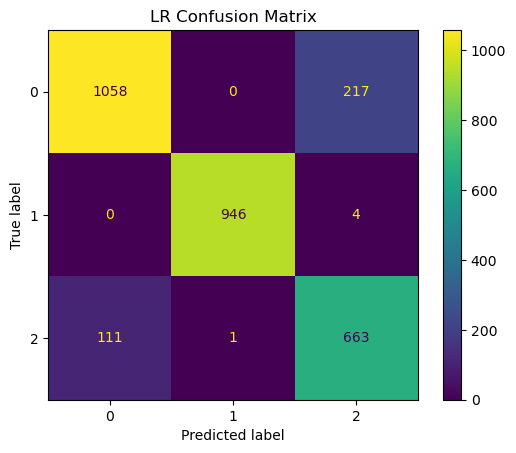

Classification report LR: 
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      1275
           1       1.00      1.00      1.00       950
           2       0.75      0.86      0.80       775

    accuracy                           0.89      3000
   macro avg       0.88      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



In [20]:
print("CV Score: {}".format(GSCV_LR.best_score_))
print("Test Score: {}".format(GSCV_LR.best_estimator_.score(x_test, y_test_enc)))
print("Best Model: ",GSCV_LR.best_estimator_)

mask = GSCV_LR.best_estimator_.named_steps['feature select'].get_support()
print("Best Features: ", df_train_enc.columns[mask])

LR_pred = GSCV_LR.predict(x_test)

import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_enc, LR_pred, labels=GSCV_LR.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GSCV_LR.classes_)
disp.plot()

plt.title("LR Confusion Matrix")
plt.show()
print("Classification report LR: \n", classification_report(y_test_enc, LR_pred))

In [21]:
import pickle

with open('BestModel_CLF_LR_Pandas.pkl','wb') as r:
    pickle.dump((GSCV_LR),r)

print("Model LR berhasil disimpan")

Model LR berhasil disimpan
